In [1]:
!pip install gitly
!pip install textblob
!pip install vaderSentiment
import pandas as pd
import numpy as np
import re
from datetime import datetime
import itertools as IT


import plotly
import plotly.express as px
import plotly.graph_objects as go
from wordcloud import WordCloud, STOPWORDS
from gitly.colab.plot import GitlyPlotter
from plotly.offline import init_notebook_mode, iplot, plot
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df_post= pd.read_csv("/content/drive/MyDrive/asalytics/reddit_posts_table.csv")
df_comment= pd.read_csv("/content/drive/MyDrive/asalytics/reddit_comments_table.csv")

In [3]:
df_post.head()

,id,title,post_text,score,total_comments,post_url,time_created,asa_id
0,r2inwn,r/choicecoin Lounge,A place for members of r/choicecoin to chat wi...,86,120,https://www.reddit.com/r/choicecoin/comments/r...,1.637916e+09,choicecoin
1,sgxogi,To an Amazing community...🎁$choice,Choice referral program is to reward and encou...,7,5,https://www.reddit.com/r/choicecoin/comments/s...,1.643623e+09,choicecoin
2,ttvgjy,It has a pulse... Choice coin is on the up!,Looks like moves higher... seems like we have ...,15,4,https://www.reddit.com/r/choicecoin/comments/t...,1.648832e+09,choicecoin
3,tq90u4,Choicecoin Dead?,NaN,6,22,https://www.reddit.com/r/choicecoin/comments/t...,1.648473e+09,choicecoin
4,tq6115,New introduction,NaN,2,0,https://app.kaafila.org/#/watch?v=QmNQm7uFRUXn...,1.648462e+09,choicecoin


In [4]:
df_comment.head()

,id,body,score,parent_id,created_at,asa_id
0,hpedoe6,Anyone think it will go back up?😅,2,t3_r2inwn,1640071042.0,choicecoin
1,hrdqoi7,"Fair to say this is a rug pull coin, yeah?",2,t3_r2inwn,1641405064.0,choicecoin
2,hmpgv8u,Hi there,1,t3_r2inwn,1638304386.0,choicecoin
3,hmpgweu,any chart to follow choice coin?,1,t3_r2inwn,1638304399.0,choicecoin
4,hmq5qo3,Hi everyone,1,t3_r2inwn,1638314603.0,choicecoin


In [5]:
sid_obj= SentimentIntensityAnalyzer()
gitly = GitlyPlotter('github')

In [6]:
df_comment['asa_id'].value_counts()

algofi            2674
Algogems          1984
choicecoin         656
Algomint           321
ZoneGameFi         118
shoshaofficial      27
Name: asa_id, dtype: int64

# Reddit Analysis

In [7]:
class reddit_analysis():
  def __init__(self):
    self.data= None


  def rename_post_columns(self, df_post):
    self.data= df_post
    self.data['post_body'] = self.data.title.astype(str).str.cat(self.data.post_text.astype(str), sep='-')
    self.data.drop(['title', 'post_text'], axis=1, inplace=True)
    self.data.rename(columns = {'id':'parent_id', "score": "post_upvotes",
                              "time_created": "post_time_created"}, inplace = True)
    return self.data


  def rename_comment_columns(self, df_comment):
    self.data= df_comment
    self.data.rename(columns= {"id": "comment_id", "body": "comment_body", "score": "comment_upvotes",
                                "created_at": "comment_time_created"}, inplace= True)
    return self.data


  def strip_commentid_prefix(self, df_comment):
    self.data= df_comment
    self.data['parent_id'] = df_comment['parent_id'].str.lstrip("t3_")
    return self.data

  
  def merge_two_dfs(self, df_post, df_comment):
    df = pd.merge(df_post, df_comment, on='parent_id', 
                   how='inner')
    return df


  def remove_URL(self, df, data:str):
    for i in df[data]:
        #df[data].replace(i, re.sub(r"http\S+", "", i), inplace= True) 
        df[data].replace(i, re.sub('((http|https):(\S+))', '', i), inplace= True)
    return df
    

  def special_character_removal(self, post_comment_text):
      data= post_comment_text.split(" ")
      data_list= []
      for i, word in enumerate(data):
        text= ""
        for char in word:
          if char.isalpha():
            text += char.lower()
        data_list.append(text)
      return " ".join(data_list)


  def access_scr(self, df, data:list):
    for i in data:
      for j in df[i]:
        df[i].replace(j, reddit_analysis().special_character_removal(j), inplace= True)
    return df


  def unix_to_utc(self, df, date_columns:list):
    for i in date_columns:
      for j in df[i]:
        if str(j).startswith("202"):
          continue
        df[i].replace(j, datetime.utcfromtimestamp(float(j)).strftime('%Y-%m-%d %H:%M:%S'), inplace= True)
      df[i]= df[i].apply(pd.to_datetime)
    return df


  def extract_date(self, df,date_columns:list):
    for x in date_columns:
        df[x +'_year'] = df[x].dt.year
        df[x +'_day'] = df[x].dt.day
        df[x +'_month'] = df[x].dt.month
        df[x + '_hour'] = df[x].dt.hour
        df[x +'_weekday'] = df[x].dt.day_name()
    return df


  def generate_sentiment(self, df):
    sentiment= {"post": [], "comment": []}
    post_score= [sid_obj.polarity_scores(i)["compound"] for i in df["post_body"]]
    comment_score= [sid_obj.polarity_scores(i)["compound"] for i in df["comment_body"]]
    for i, j in zip(post_score, comment_score):
      i = "negative" if i<0 else "positive" if i > 0 else "neutral"
      j = "negative" if j<0 else "positive" if j > 0 else "neutral"
      sentiment["post"].append(i)
      sentiment["comment"].append(j)
    df["post_sentiment"] = sentiment["post"]
    df["comment_sentiment"]= sentiment["comment"]
    return df

  def change_dtypes(self, df):
    df['comment_upvotes']= df['comment_upvotes'].astype(int)
    return df


  def all(self, df_post, df_comment):
    df_post= reddit_analysis().rename_post_columns(df_post)
    df_comment= reddit_analysis().rename_comment_columns(df_comment)
    df_comment= reddit_analysis().strip_commentid_prefix(df_comment)
    df= reddit_analysis().merge_two_dfs(df_post, df_comment)

    df= reddit_analysis().remove_URL(df, "post_body")
    df= reddit_analysis().remove_URL(df, "comment_body")
    df= reddit_analysis().access_scr(df, ["post_body", "comment_body"])
    df = reddit_analysis().unix_to_utc(df, ['post_time_created', "comment_time_created"])
    df = reddit_analysis().extract_date(df, ['post_time_created', 'comment_time_created'])
    df= reddit_analysis().generate_sentiment(df)
    df= reddit_analysis().change_dtypes(df)
    return df

In [8]:
data= reddit_analysis().all(df_post, df_comment)

In [9]:
def choose_asa(df):
  asa = input("Select an ASA to analyze: ")
  df = df[df['asa_id_x'].str.contains(asa, case = False)]
  df.reset_index(inplace = True)
  return df

In [10]:
algofi_data= choose_asa(data)

Select an ASA to analyze: algofi


In [11]:
choice_data= choose_asa(data)

Select an ASA to analyze: choicecoin


In [12]:
algogems_data= choose_asa(data)

Select an ASA to analyze: algogems


In [13]:
algomint_data= choose_asa(data)

Select an ASA to analyze: algomint


In [14]:
data.columns

Index(['parent_id', 'post_upvotes', 'total_comments', 'post_url',
       'post_time_created', 'asa_id_x', 'post_body', 'comment_id',
       'comment_body', 'comment_upvotes', 'comment_time_created', 'asa_id_y',
       'post_time_created_year', 'post_time_created_day',
       'post_time_created_month', 'post_time_created_hour',
       'post_time_created_weekday', 'comment_time_created_year',
       'comment_time_created_day', 'comment_time_created_month',
       'comment_time_created_hour', 'comment_time_created_weekday',
       'post_sentiment', 'comment_sentiment'],
      dtype='object')

# Reddit Visualizations

In [15]:
class reddit_plot():
  def __init__(self, data, entity:str):
    self.data= data
    self.entity= entity


  def date_selector(self):
    enquiry= input("Would you like to select date range: enter yes/no: ")
    if enquiry == "yes":
      start= input("From ? request format 2021-11-01: ")
      end= input("To ? request format 2021-12-31: ")
      xaxis_range= [str(start), str(end)]
      return xaxis_range
    else:
      return None


  def plot_bar(self, x_axis= None, y_axis= None, text= None, time= None):
    entity= self.entity
    asa_name= self.data['asa_id_x'].mode()[0]
    trace= go.Bar(x= x_axis, y= y_axis,
                  marker= dict(color='#228B22', line= dict(color= '#228B22', width= 3.0)),
                   text= text)
    data= [trace]
    layout= go.Layout(barmode= 'stack', title= f"Trend of {entity} in {time} for {asa_name}",
                      xaxis= dict(title=f'{time} of the week'),
                      yaxis= dict(title= "Count"), annotations= [{ "font": { "size": 34}, "x": 1, "y": 2}])
    fig= go.Figure(data= data, layout= layout)
    fig.update_layout(yaxis={'showgrid': True}
                  ,xaxis={'showgrid': True}
                  #,template='plotly_dark'
                  ,hovermode="x"
                  ,legend=dict(y=1, x=1, font=dict(size=8))
                  ,height=500
                  ,font=dict(size=15, color='gray')
                  ,title={'y':0.95
                          ,'x':0.5
                          ,'xanchor': 'center'
                          ,'yanchor': 'top'
                          ,'font_size':20
                          ,'font_color':'black'})
    return fig


  def plot_scatter(self, x_axis= None, y_axis= None, text= None, time= None):
    entity= self.entity
    asa_name= self.data['asa_id_x'].mode()[0]
    trace= go.Scatter(x= x_axis, y= y_axis,
                        mode= 'lines+markers',
                        marker= dict(color= '#228B22'),
                        text= text)
    
    data= [trace]
    layout= dict(title = f'Trend of {entity} per {time} for {asa_name}', 
                xaxis= dict(title=f'{time} of the day'),
                 yaxis= dict(title= "Count"))
    fig= go.Figure(data= data, layout= layout)
    fig.update_layout(yaxis={'showgrid': True}
                     ,xaxis={'showgrid': True}
                     #,template='plotly_dark'
                     ,hovermode="x"
                     ,legend=dict(y=1, x=1, font=dict(size=8))
                     ,height=500
                     ,font=dict(size=15, color='gray')
                     ,title={'y':0.95
                             ,'x':0.5
                             ,'xanchor': 'center'
                             ,'yanchor': 'top'
                             ,'font_size':20
                             ,'font_color':'black'})

    return fig


  def check_upvotes(self, days= False, hour= False, month= False):
    df, entity= self.data, self.entity
    if days== True:
      val= "days"
      grouped_df= df.groupby('post_time_created_weekday')[entity].sum()
      x_axis, y_axis, text= grouped_df.index, grouped_df, df.asa_id_x
      fig= reddit_plot(df, entity).plot_bar(x_axis, y_axis, text, val)
      return gitly.show(fig)

    elif hour== True:
      val= "hour"
      grouped_df= df.groupby('post_time_created_hour')[entity].sum()
      x_axis, y_axis, text= grouped_df.index, grouped_df, df.asa_id_x
      fig= reddit_plot(df, entity).plot_scatter(x_axis, y_axis, text, val)
      return gitly.show(fig)

    elif month== True:
      val= "month"
      grouped_df= df.groupby('post_time_created_month')[entity].sum()
      x_axis, y_axis, text= grouped_df.index, grouped_df, df.asa_id_x
      fig= reddit_plot(df, entity).plot_scatter(x_axis, y_axis, text, val)
      fig.update_layout(xaxis= dict(title= "Month of the Year"))
      return gitly.show(fig)

    else:
      entity= self.entity
      asa_name= self.data['asa_id_x'].mode()[0]
      grouped_df= df.groupby('post_time_created')[entity].sum()
      x_axis, y_axis, text= grouped_df.index, grouped_df, df.asa_id_x
      fig= reddit_plot(df, "total_comments").plot_scatter(x_axis, y_axis, text)
      xaxis_range= reddit_plot(df, "total_comments").date_selector()
      fig.update_layout(xaxis_range=xaxis_range, title_text=f"Time with the most engagements for {asa_name}", xaxis= dict(title= "Date"))
      fig.update_layout(yaxis_range=[0,1500])
      return gitly.show(fig)


  def most_upvoted_asa(self):
    df= self.data
    entity= self.entity
    grouped_df= df.groupby('asa_id_x')[entity].sum()
    x_axis, y_axis, text= grouped_df.index, grouped_df, df.asa_id_x
    fig= reddit_plot(df, entity).plot_bar(x_axis, y_axis)
    fig.update_layout(title_text="Most Upvoted ASA", xaxis= dict(title= "ASA Names"))
    return gitly.show(fig)


  def get_wordcloud(self):
    df= self.data
    entity= self.entity
    stopwords = set(STOPWORDS)
    plt.subplots(figsize=(15,8))
    cloud= WordCloud(stopwords= stopwords, min_font_size = 10, background_color='white').generate(" ".join(df[entity]))

    plt.imshow(cloud)
    plt.axis('off')
    plt.tight_layout(pad = 0)
    return plt.show()


  def get_sentiment(self):
    df= self.data
    entity= self.entity
    asa_name= self.data['asa_id_x'].mode()[0]
    fig = px.histogram(df, x= entity, barmode= "group", color= entity, title= f"Sentiment Analysis for {asa_name}")
    fig.update_layout(yaxis={'showgrid': True}
                     ,xaxis={'showgrid': True}
                     #,template='plotly_dark'
                     ,hovermode="x"
                     ,legend=dict(y=1, x=1, font=dict(size=8))
                     ,height=500
                     ,font=dict(size=15, color='gray')
                     ,title={'y':0.95 ,'x':0.5,'xanchor': 'center','yanchor': 'top','font_size':20, 'font_color':'black'})
    return gitly.show(fig)

# ALGOFI

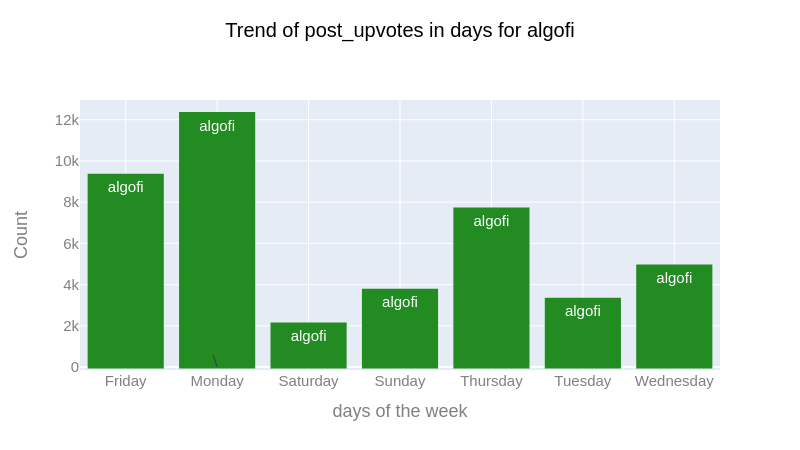

In [16]:
reddit_plot(algofi_data, "post_upvotes").check_upvotes(days= True)

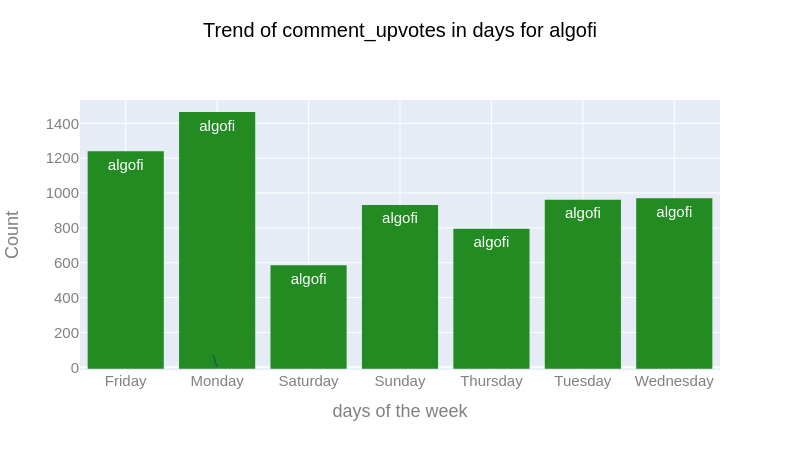

In [17]:
reddit_plot(algofi_data, "comment_upvotes").check_upvotes(days= True)

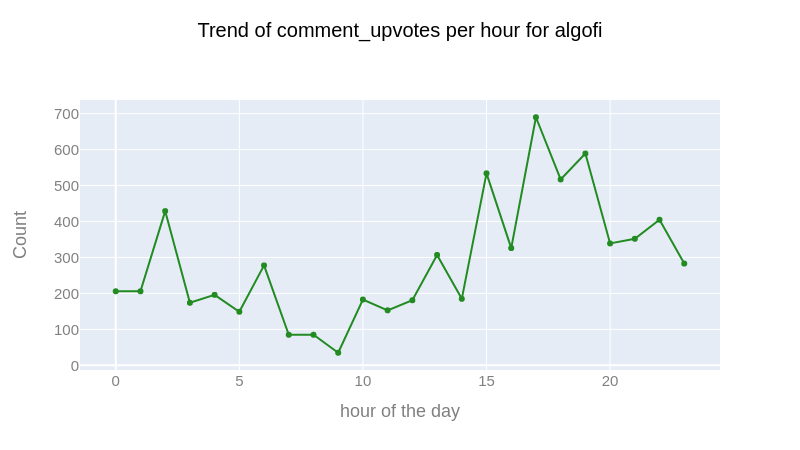

In [18]:
reddit_plot(algofi_data, "comment_upvotes").check_upvotes(hour= True)

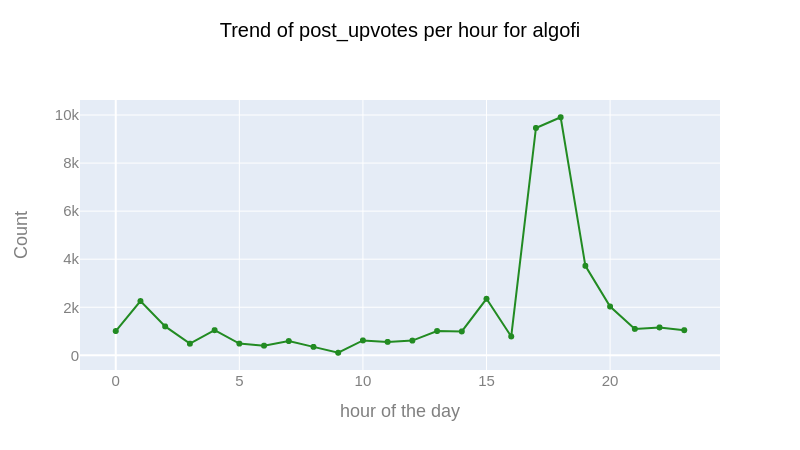

In [19]:
reddit_plot(algofi_data, "post_upvotes").check_upvotes(hour= True)

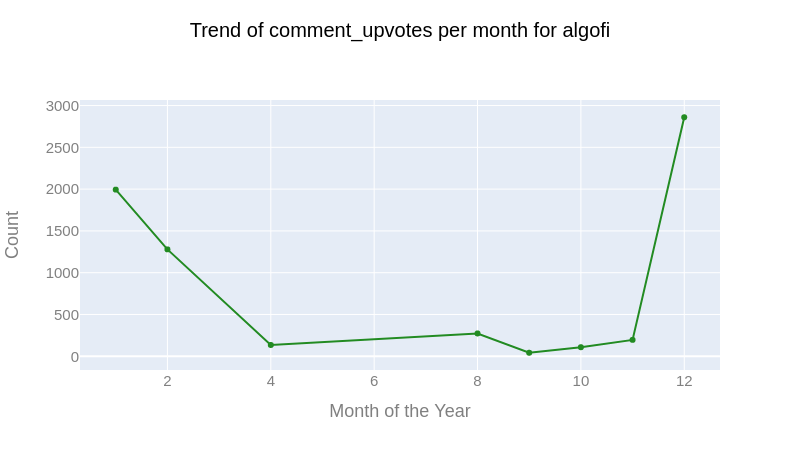

In [20]:
reddit_plot(algofi_data, "comment_upvotes").check_upvotes(month= True)

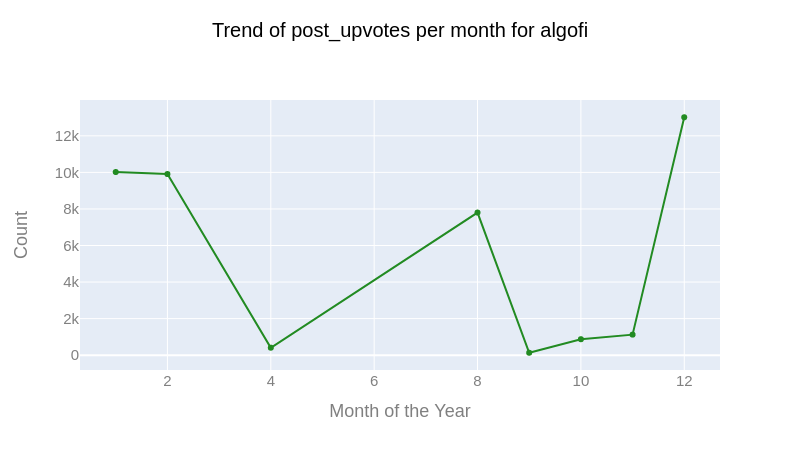

In [21]:
reddit_plot(algofi_data, "post_upvotes").check_upvotes(month= True)

Would you like to select date range: enter yes/no: yes
From ? request format 2021-11-01: 2021-08-01
To ? request format 2021-12-31: 2022-01-01


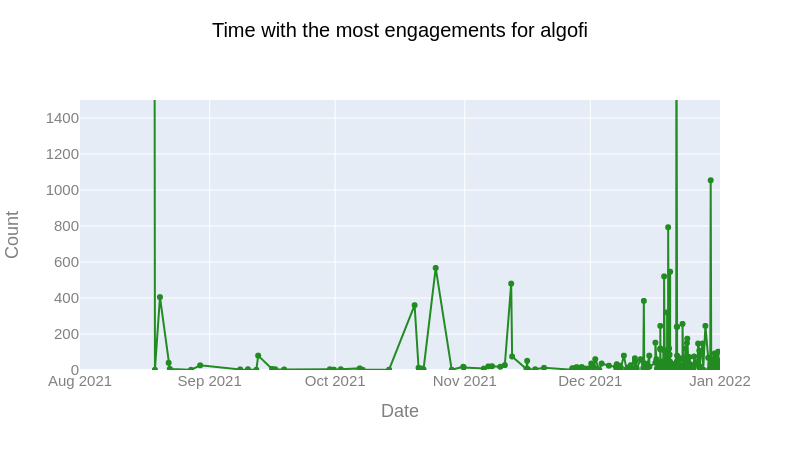

In [22]:
reddit_plot(algofi_data, "total_comments").check_upvotes()

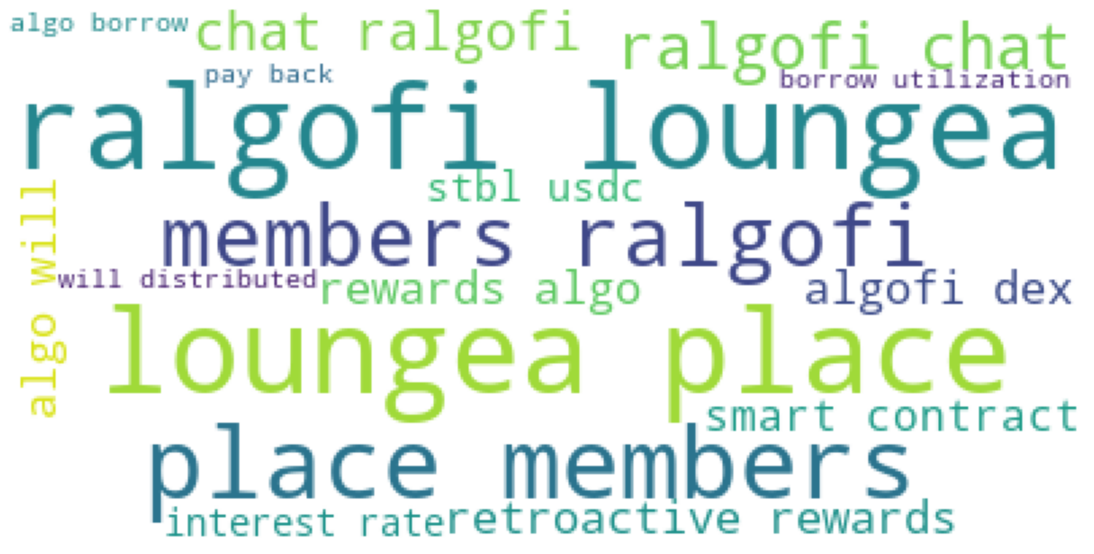

In [23]:
reddit_plot(algofi_data, "post_body").get_wordcloud()

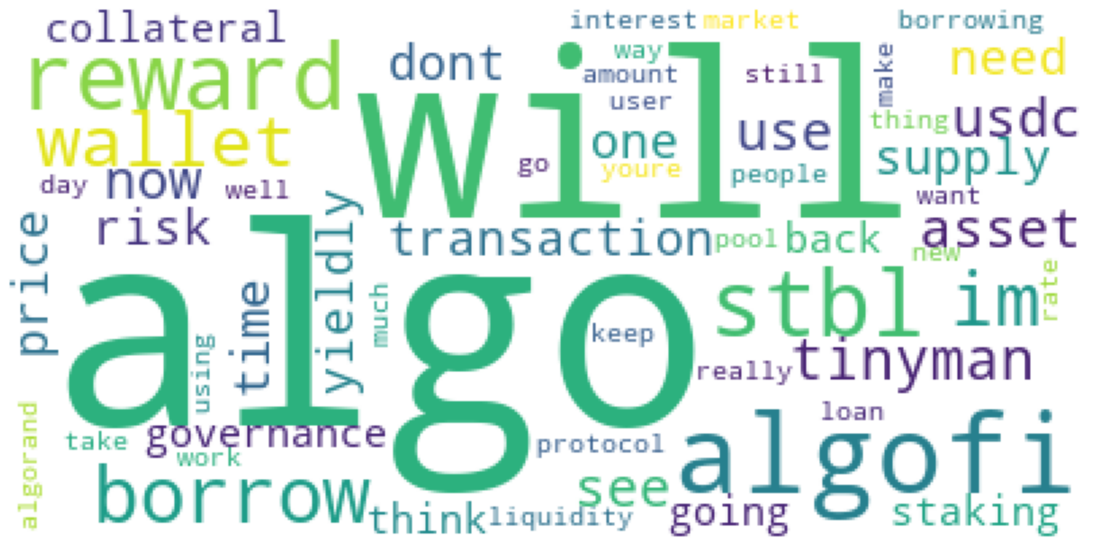

In [24]:
reddit_plot(algofi_data, "comment_body").get_wordcloud()

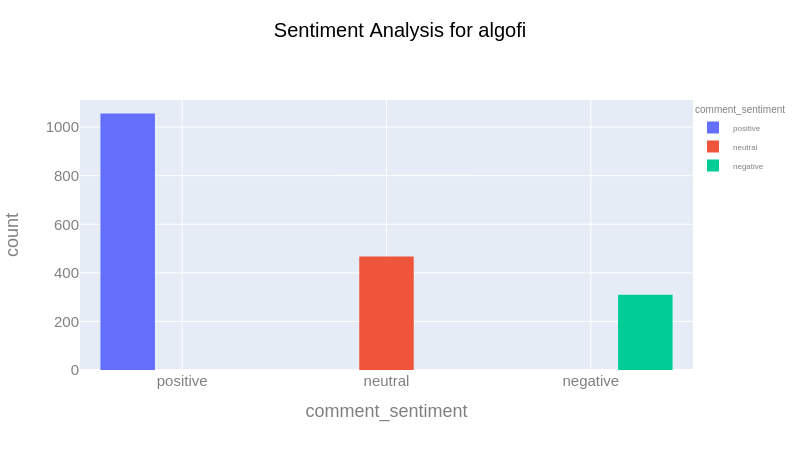

In [25]:
reddit_plot(algofi_data, "comment_sentiment").get_sentiment()

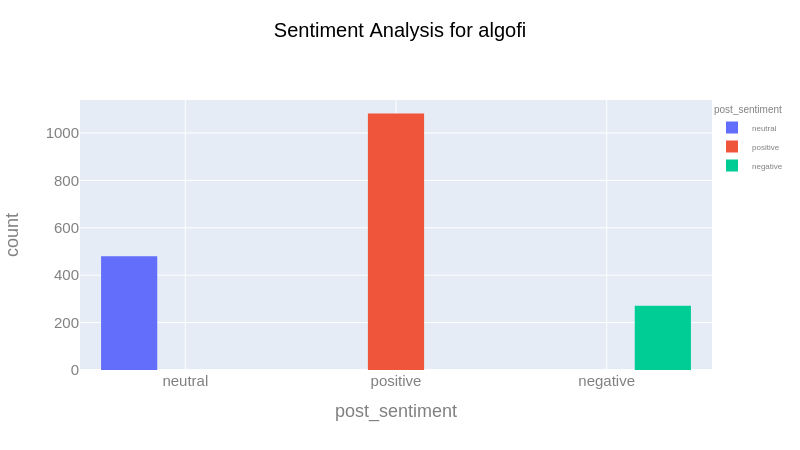

In [26]:
reddit_plot(algofi_data, "post_sentiment").get_sentiment()

# ALGOGEMS

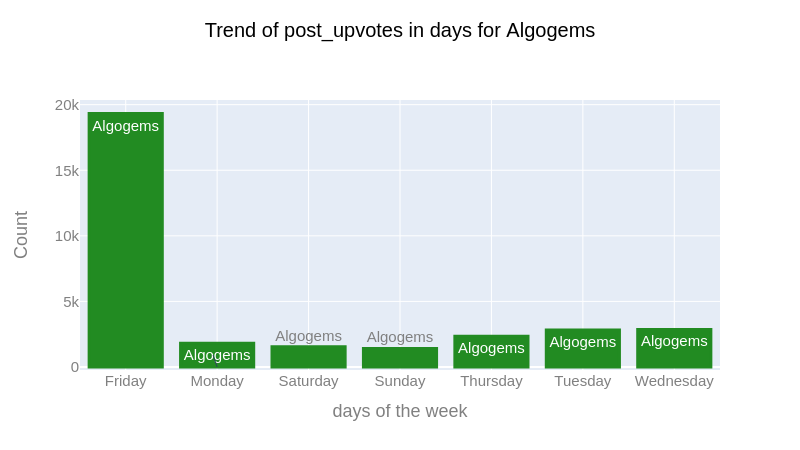

In [27]:
reddit_plot(algogems_data, "post_upvotes").check_upvotes(days= True)

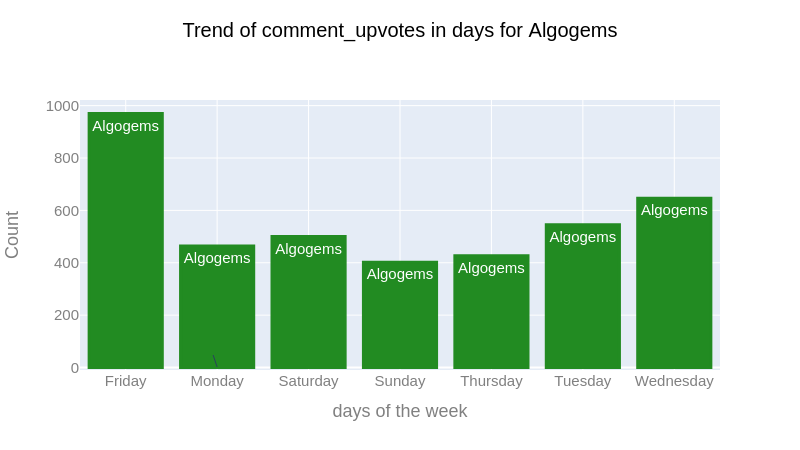

In [28]:
reddit_plot(algogems_data, "comment_upvotes").check_upvotes(days= True)

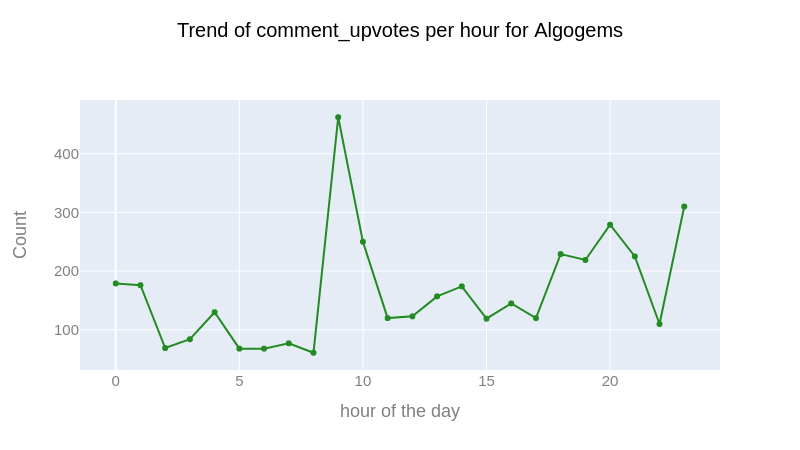

In [29]:
reddit_plot(algogems_data, "comment_upvotes").check_upvotes(hour= True)

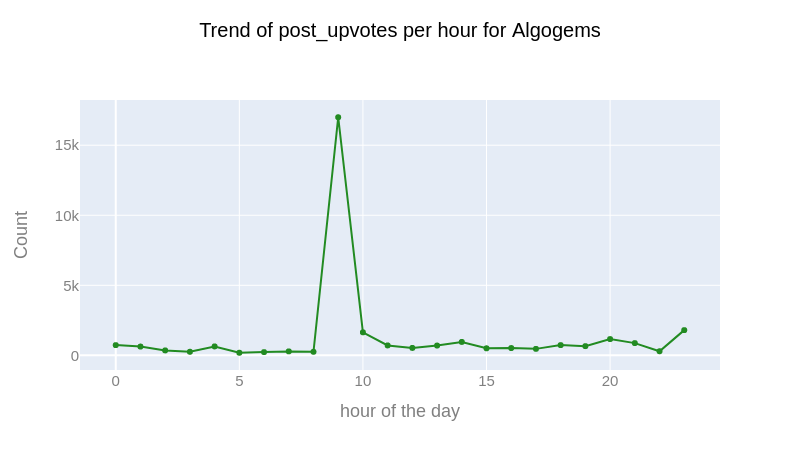

In [30]:
reddit_plot(algogems_data, "post_upvotes").check_upvotes(hour= True)

Would you like to select date range: enter yes/no: yes
From ? request format 2021-11-01: 2021-06-01
To ? request format 2021-12-31: 2022-01-01


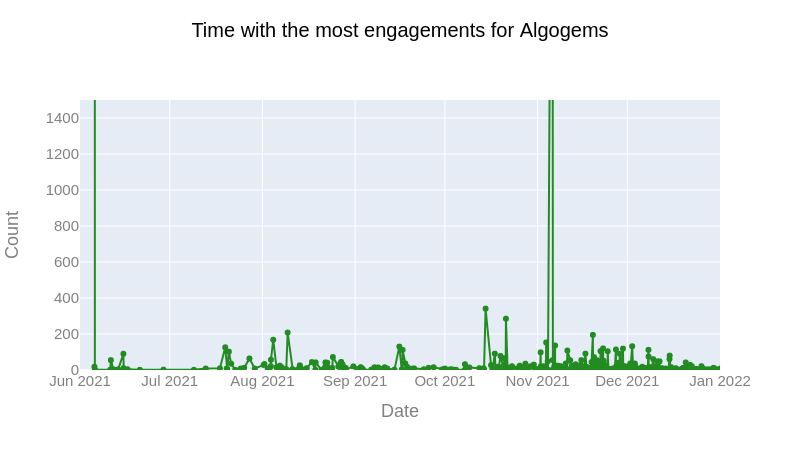

In [31]:
reddit_plot(algogems_data, "total_comments").check_upvotes()

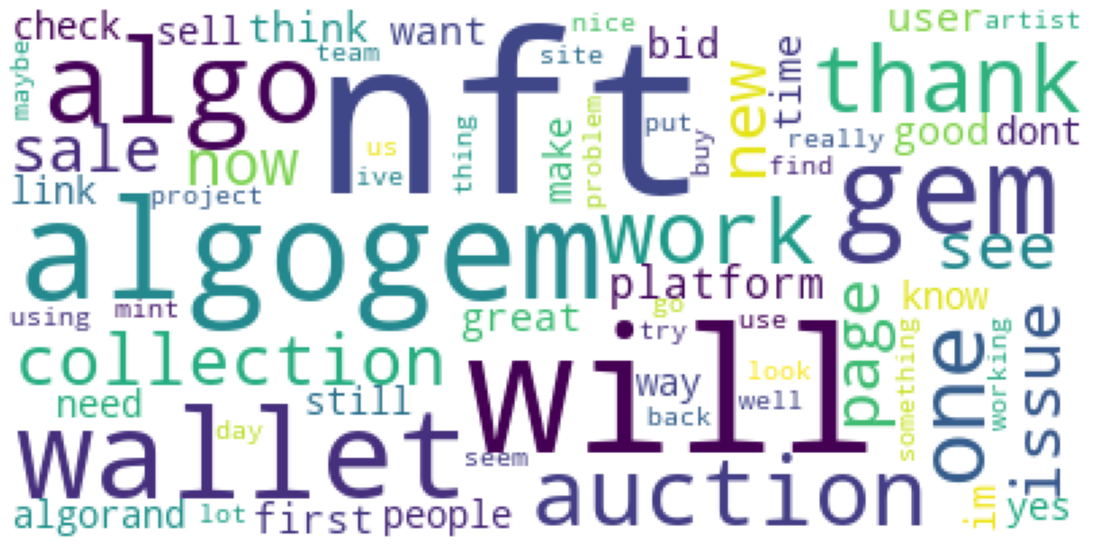

In [32]:
reddit_plot(algogems_data, "comment_body").get_wordcloud()

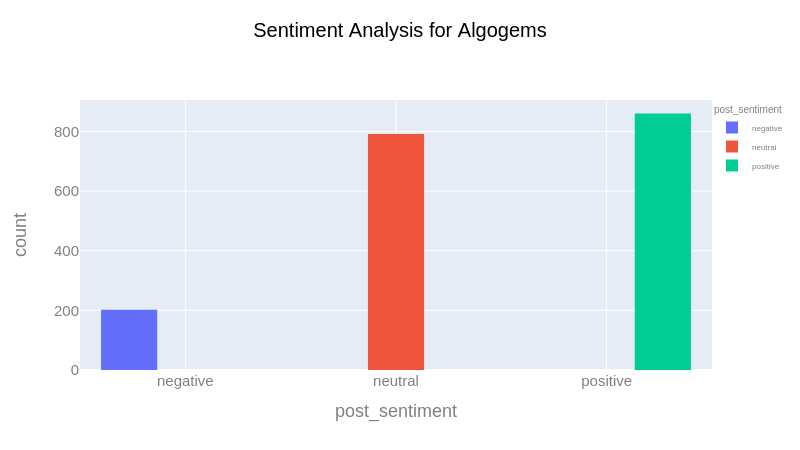

In [33]:
reddit_plot(algogems_data, "post_sentiment").get_sentiment()

# CHOICECOIN

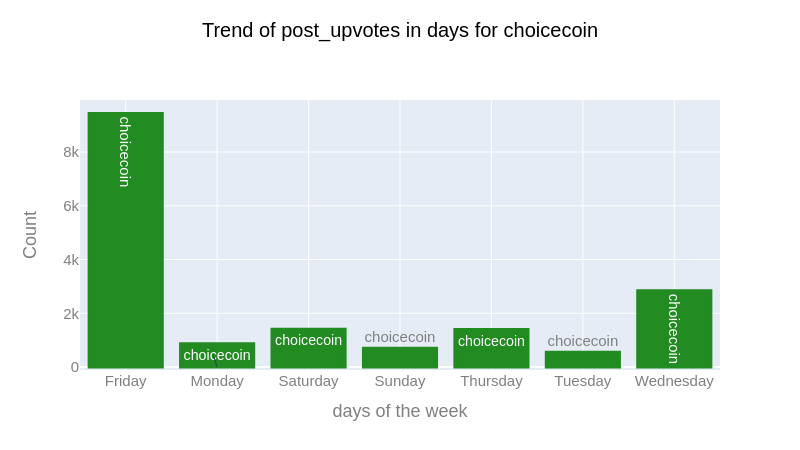

In [34]:
reddit_plot(choice_data, "post_upvotes").check_upvotes(days= True)

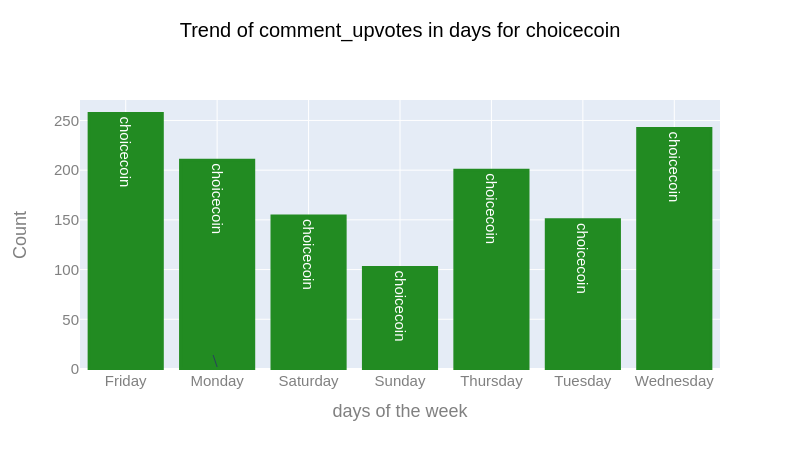

In [35]:
reddit_plot(choice_data, "comment_upvotes").check_upvotes(days= True)

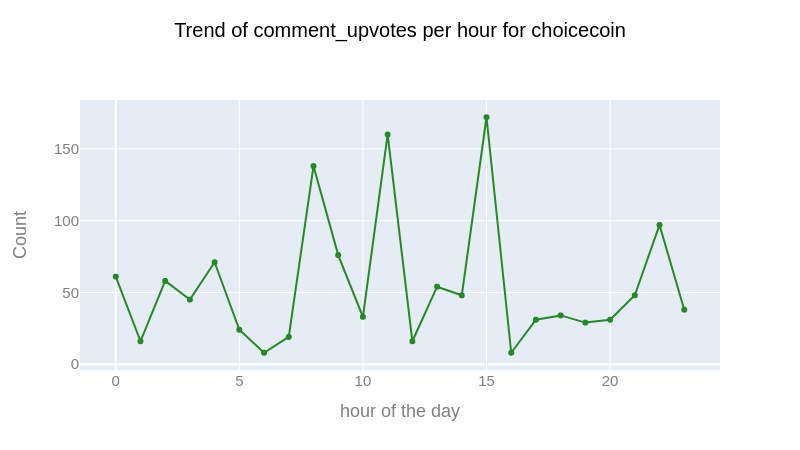

In [36]:
reddit_plot(choice_data, "comment_upvotes").check_upvotes(hour= True)

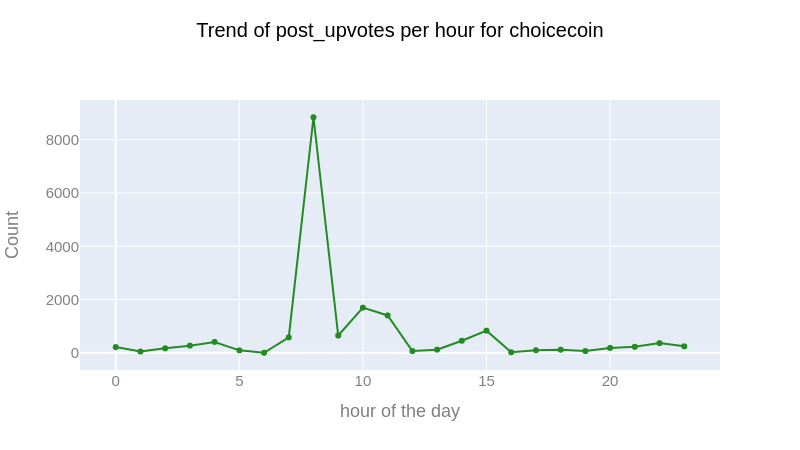

In [37]:
reddit_plot(choice_data, "post_upvotes").check_upvotes(hour= True)

Would you like to select date range: enter yes/no: yes
From ? request format 2021-11-01: 2021-11-01
To ? request format 2021-12-31: 2022-03-01


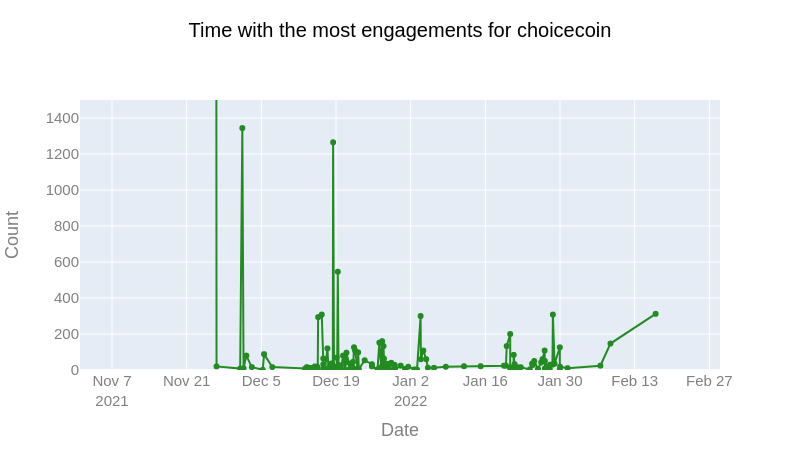

In [50]:
reddit_plot(choice_data, "total_comments").check_upvotes()

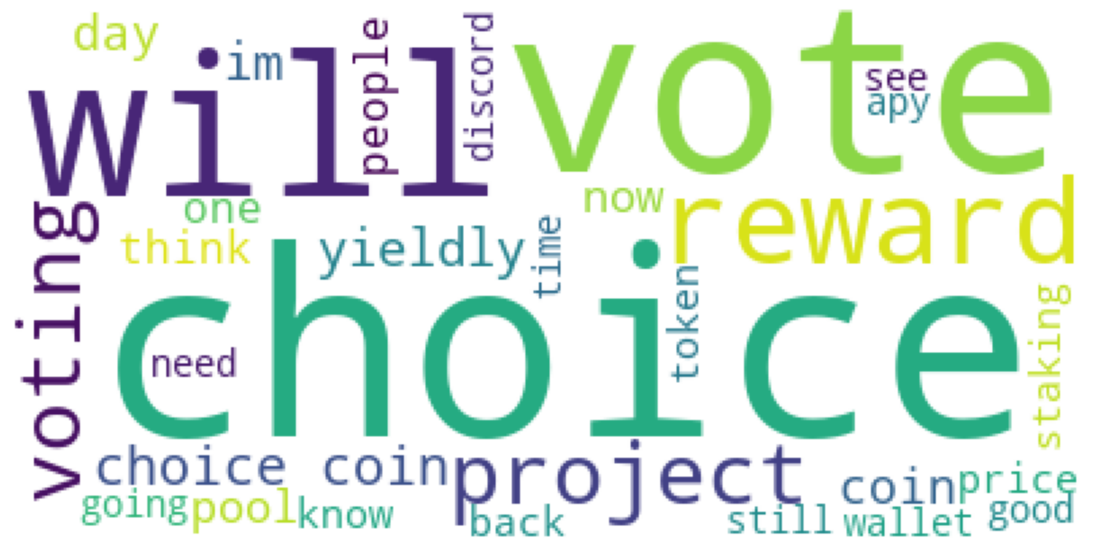

In [39]:
reddit_plot(choice_data, "comment_body").get_wordcloud()

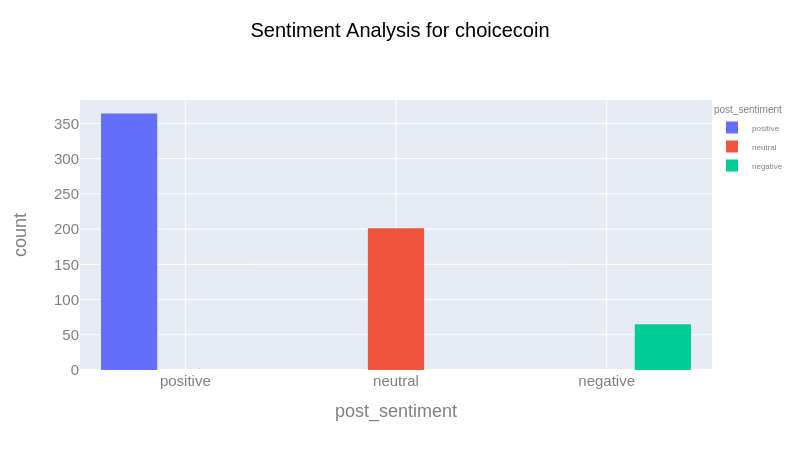

In [40]:
reddit_plot(choice_data, "post_sentiment").get_sentiment()

# ALGOMINT

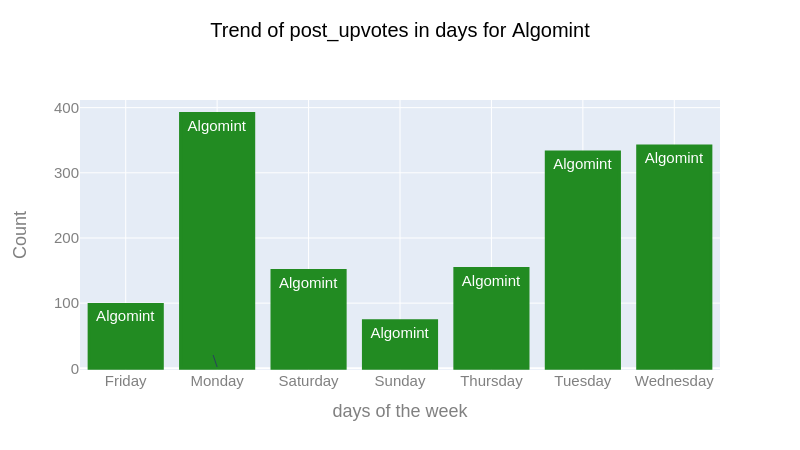

In [41]:
reddit_plot(algomint_data, "post_upvotes").check_upvotes(days= True)

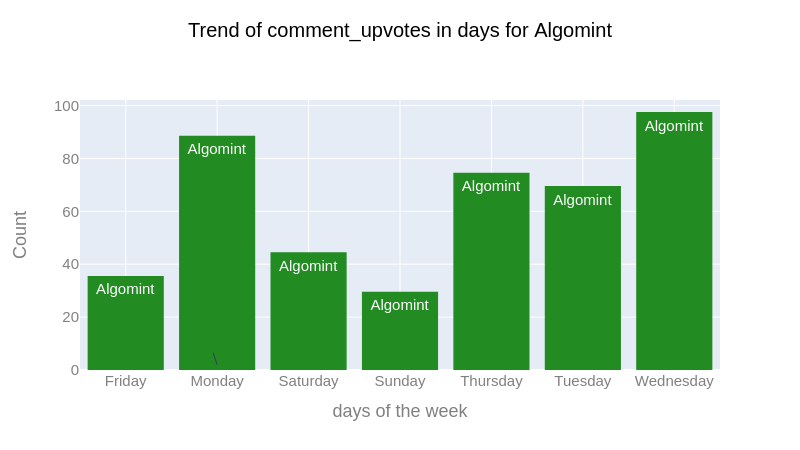

In [42]:
reddit_plot(algomint_data, "comment_upvotes").check_upvotes(days= True)

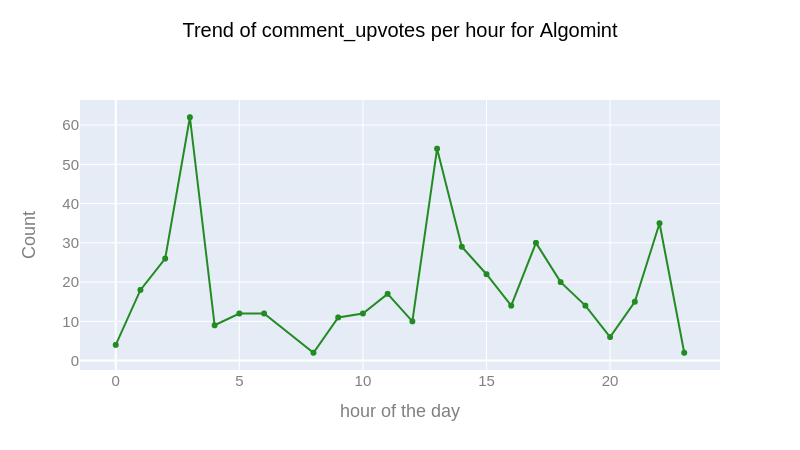

In [43]:
reddit_plot(algomint_data, "comment_upvotes").check_upvotes(hour= True)

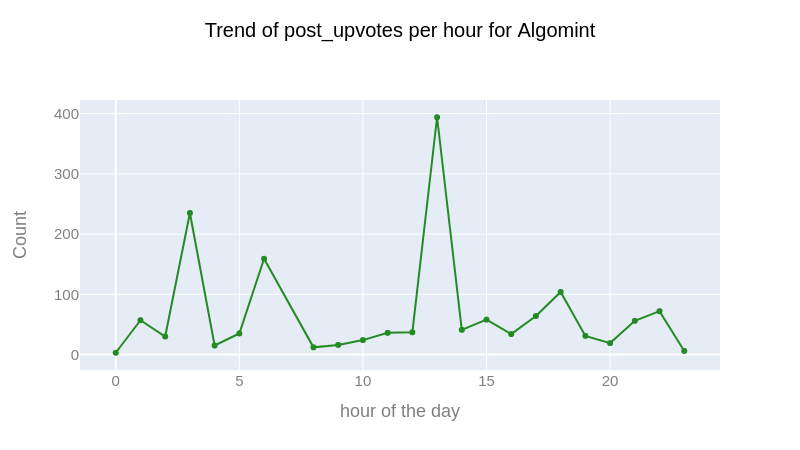

In [44]:
reddit_plot(algomint_data, "post_upvotes").check_upvotes(hour= True)

Would you like to select date range: enter yes/no: yes
From ? request format 2021-11-01: 2021-09-01
To ? request format 2021-12-31: 2022-01-01


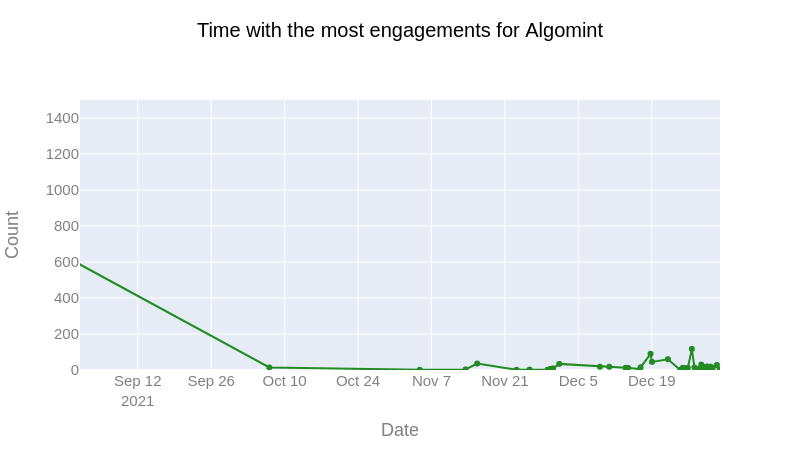

In [45]:
reddit_plot(algomint_data, "total_comments").check_upvotes()

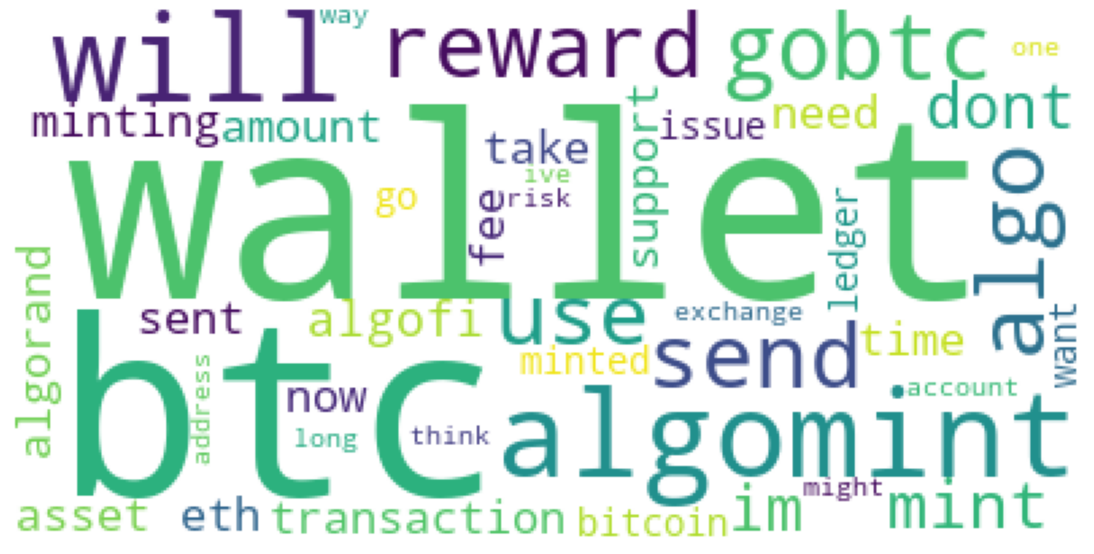

In [46]:
reddit_plot(algomint_data, "comment_body").get_wordcloud()

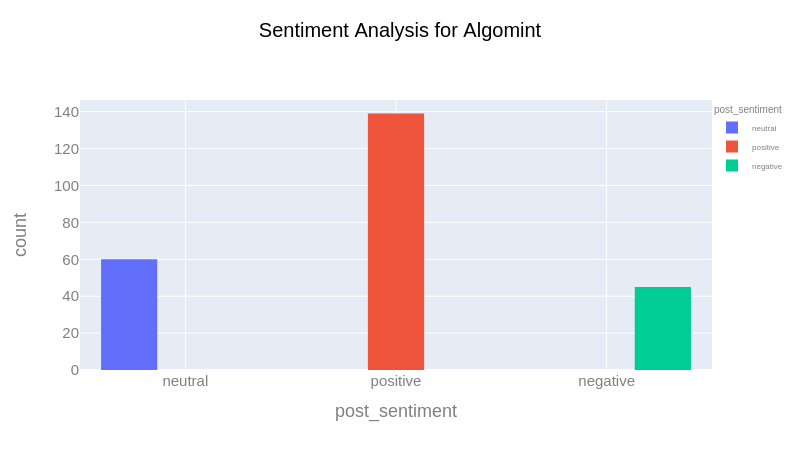

In [47]:
reddit_plot(algomint_data, "post_sentiment").get_sentiment()

# ALL AVAILABLE ASAs

In [48]:
def get_all(df_post, df_comment):
  df= reddit_analysis().merge_two_dfs(df_post, df_comment)
  return df
new_df = get_all(df_post, df_comment)

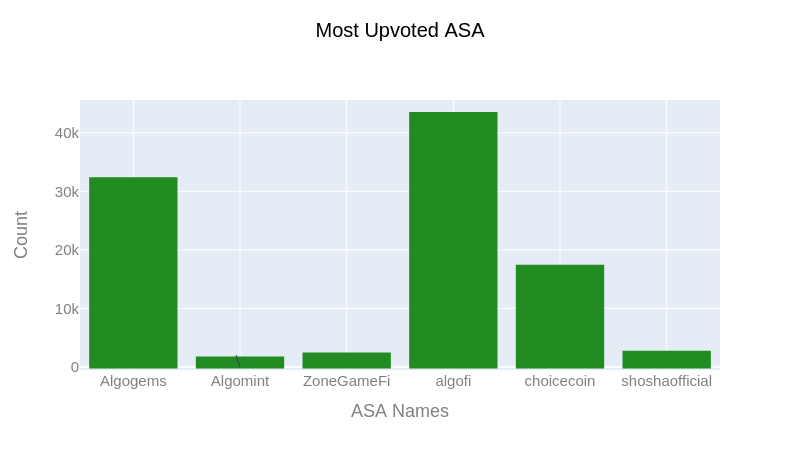

In [49]:
reddit_plot(new_df, "post_upvotes").most_upvoted_asa()